# Implementing a Feedforward Neural Network From Scratch

The aim of this project is to code and train a feedforward neural network to classify credit card transactions as fraudulent (positive) or not fraudulent.
The dataset being used is from Kaggle, and contains transactions made by credit cards for 2 days in September 2013 by European cardholders. The dataset is unbalanced - there are only 492 fraudulent transactions out of the total 284,807 transactions.



# Preprocessing the input data
First, we will import the dependencies - **numpy**, the python linear algebra library, **pandas** to load and preprocess the input data and **matplotlib.pyplot** for visualisation purposes.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Then we need to load the input data from the csv file provided by Kaggle:

In [4]:
dataset = pd.read_csv("creditcard.csv") #create a new dataframe containing the input data
dataset.head() #this outputs the first five rows of the dataset for visualisation purposes

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Next, we need to preprocess the input data. We will not be considering the time each transaction occurred, since the overall timeframe (2 days) is too short to provide any meaningful time-contextual trends. We will randomly shuffle the examples to eliminate bias in training/testing. 
Having done this, we will split the dataframe into the input features *X* and the class label *Y*.
We need to then standardise the input features:
$$X = \frac{X-\mu}{\sqrt{\sigma^2 + \epsilon}}$$ where $\mu$ = mean and $\sqrt{\sigma^2 + \epsilon}$ = standard deviation of each feature ($\epsilon = 10^{-7}$ and is used for numerical stability).
We would also like the dimensions to be a *(num_features) x (num_examples)* matrix for X, and a *1 x (num_examples)* matrix for Y, so we will have to transpose the matrices to achieve this.

In [5]:
#randomly shuffle the data 
dataset = dataset.sample(frac=1).reset_index(drop=True)
#split into X and Y and remove the "Time" feature
X = dataset.iloc[:,1:30] 
Y = dataset.iloc[:,30:]

#standardise the input features
X-=X.mean()
X/=np.sqrt(X.std()**2 + 1e-7)

#convert dataframe to a numpy 2D Array (matrix)
X = X.as_matrix()
Y = Y.as_matrix()
X = X.T
Y = Y.T
print("Dimensions of X: " + str(X.shape))
print("Dimensions of Y: " + str(Y.shape))

Dimensions of X: (29, 284807)
Dimensions of Y: (1, 284807)


Next, since we have randomly shuffled the data, we can split the data into 3 sets - training, cross-validation (dev) and a test set. Since we have 284807 examples, we'll split this in an ~80:10:10 split. This works out to roughly be a 
227847:28480:28480 split. To keep the code clean, we can bundle the 6 matrices in a python dictionary.

In [6]:
TrainTestDevSets = {}

TrainTestDevSets["X_train"] = X[:,:227847]
TrainTestDevSets["Y_train"] = Y[:,:227847]

TrainTestDevSets["X_dev"] = X[:,227847:256327]
TrainTestDevSets["Y_dev"] = Y[:,227847:256327]

TrainTestDevSets["X_test"] = X[:,256327:]
TrainTestDevSets["Y_test"] = Y[:,256327:]


# Creating the neural network:

Having preprocessed our data into matrices, it is now time to create the feedforward neural network. First we will initialise the initial values of our hyperparameters (stored in a python dictionary for tidiness):

In [7]:
hyperparameters={}
hyperparameters["num_epochs"] = 10 #number of passes through the training set
hyperparameters["batch_size"] = 128 #number of examples trained upon in each step of training
hyperparameters["layers_units"] = [X.shape[0], 128, 64, 32, 1] #layer 0 is the input layer
hyperparameters["lambd"] = 1 #regularisation parameter 
hyperparameters["learning_rate"] = 1e-3

Now we need to initialise parameters: the weights and biases for each layer.

The weights for layer *$l$* are stored in *$ W^{(l)}$*, a *$n_l$ x $n_{(l-1)}$* matrix, where *$n_l$* is the number of units in layer *$l$*. 
We randomly initialise the weights from a Gaussian distribution ($\mu=0, \sigma =1$) to break symmetry, and multiply these values by 0.001 to achieve quicker convergence, since smaller weights will ensure that the sigmoid activation function in the final layer will not become saturated, which would lead to gradients ~ 0, so resulting in slower learning.

The biases for layer *$l$* are stored in *$ b^{(l)}$*, which is a *$n_l$ x 1* matrix.

In [8]:
def initialise_parameters(layers_units):
    parameters = {}            # create a dictionary containing the parameters
    for l in range(1, len(layers_units)):
        parameters['W' + str(l)] = 0.001* np.random.randn(layers_units[l],layers_units[l-1])
        parameters['b' + str(l)] = np.zeros((layers_units[l],1))
    return parameters

The activation functions $g(z)$ we will be using are the ReLU function $g(z) = max(0,z)$ in the hidden layers and the sigmoid function $g(z) = \frac{1}{1 + e^{-z}}$ in the final layer. The activation functions introduce non-linearities into the overall neural network, and the sigmoid is used to generate a value between 0 and 1 - the probability that the input is a fraudulent transaction.

NB: Although the ReLU function is technically non-differentiable when $z=0$, in practice we can set the derivative=0 at $z=0$.

In [9]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def relu(z, deriv = False):
    if(deriv):
        return z>0
    else:
        return np.multiply(z, z>0)

We can now write the code for the forward propagation step.

In each layer $l$ , we matrix multiply the output of the previous layer $A^{(l-1)}$  by a weight matrix $W^{(l)}$ and then add a bias term $b^{(l)}$. We then take the result $Z^{(l)}$ and apply the activation function $g(z)$ to it to get the output $A^{(l)}$. $L$ = number of layers.
The equations are thus:
$$Z^{(l)}=W^{(l)}A^{(l-1)}$$
$$A^{(l)}=g(Z^{(l)})$$

In [10]:
def forward_propagation(X,parameters):
    cache = {}
    L = len(parameters)//2 #final layer
    cache["A0"] = X #ease of notation since input = layer 0
    for l in range(1, L):
        cache['Z' + str(l)] = np.dot(parameters['W' + str(l)],cache['A' + str(l-1)]) + parameters['b' + str(l)]
        cache['A' + str(l)] = relu(cache['Z' + str(l)])
    #final layer
    cache['Z' + str(L)] = np.dot(parameters['W' + str(L)],cache['A' + str(L-1)]) + parameters['b' + str(L)]
    cache['A' + str(L)] = sigmoid(cache['Z' + str(L)])
    return cache 

Next we can compute the cost function - this is the objective function the neural network will aim to minimise during training:

We are using the cross-entropy loss function $J(W^{(1)}, b^{(1)},...)$ since it performs better than Mean Squared Error for classification tasks. We will also add an L2 regularisation term - by tuning the $\lambda$ parameter, we can reduce overfitting.

$m$ = number of training examples, $(x^{(i)},y^{(i)})$ is the $i^{th}$ training example.
$$J(W^{(1)}, b^{(1)},...) = -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{(L) (i)}\right) + (1-y^{(i)})\log\left(1- a^{(L)(i)}\right)) + \frac{\lambda}{2m}\sum\limits_{l = 1}^{L}\|{W^{(l)}}\|^{2}$$



In [11]:
def cost_function(AL,Y,parameters,lambd):
    cost = 0
    m = Y.shape[1]
    L = len(parameters)//2
    cost += (-1/m)*( np.sum(np.multiply(Y,np.log(AL))) + np.sum(np.multiply((1-Y),np.log(1-AL))))
    regularisation_term = 0
    for l in range(1,L+1):
        regularisation_term += np.sum(np.square(parameters["W" + str(l)]))
    regularised_cost = cost + (lambd/(2*m))*regularisation_term
    return regularised_cost

Now we will code the backpropagation algorithm. This will enable us to calculate the partial derivative of the cost function with respect to each of the weights and biases in each of the layers of the network. The equations can be derived using the multivariable chain rule and are:
$$\frac{\partial \mathcal{J} }{\partial Z^{(L)}} = A^{(L)} - Y$$ 

$$ \frac{\partial \mathcal{J} }{\partial Z^{(l)}} = \frac{\partial \mathcal{J} }{\partial A^{(l)}}*g^{'}(Z^{(l)})$$

$$ \frac{\partial \mathcal{J} }{\partial W^{(l)}} = \frac{1}{m}\frac{\partial \mathcal{J} }{\partial Z^{(l)}} A^{(l-1) T} $$

$$ \frac{\partial \mathcal{J} }{\partial b^{(l)}} = \frac{1}{m} \sum_{i = 1}^{m} \frac{\partial \mathcal{J} }{\partial Z^{(l)(i)}}$$

$$ \frac{\partial \mathcal{J} }{\partial A^{(l-1)}} = W^{(l) T} \frac{\partial \mathcal{J} }{\partial Z^{(l)}} $$


In [12]:
def backpropagation(cache,Y,parameters,lambd):
    L = len(parameters)//2 
    m = Y.shape[1]
    grads = {}
    grads["dZ" + str(L)]= cache["A" + str(L)] - Y
    grads["dW" + str(L)]= (1/m)*np.dot(grads["dZ" + str(L)],cache["A" + str(L-1)].T) 
    grads["dW" + str(L)]+= (lambd/m)*parameters["W" + str(L)]  
    grads["db" + str(L)]= (1/m)*np.sum(grads["dZ" + str(L)],axis=1,keepdims=True)
    for l in range(L-1,0,-1):
        grads["dA" + str(l)]= np.dot(parameters["W" + str(l+1)].T,grads["dZ" + str(l+1)])
        grads["dZ" + str(l)]= np.multiply(grads["dA" + str(l)], relu(cache["Z" + str(l)], deriv = True))
        grads["dW" + str(l)]= (1/m)*np.dot(grads["dZ" + str(l)],cache["A" + str(l-1)].T) 
        grads["dW" + str(l)]+= (lambd/m)*parameters["W" + str(l)]  
        grads["db" + str(l)]= (1/m)*np.sum(grads["dZ" + str(l)],axis=1,keepdims=True)
    return grads

We need to have an evaluation metric to see if the model is actually learning - since the data is skewed, accuracy is not a good metric as it can be misleading (for example, if 90% of the data was non-fraudulent the model could be hard-coded to evaluate everything as not fraudulent and get a 90% accuracy). 

Instead we will use the F1 score. The equation for F1 score is as follows:
$$ Precision = \frac{True \space Positive}{True\space Positive + False \space Positive}$$
    
$$Recall = \frac{True \space Positive}{True\space Positive + False \space Negative} $$

$$F1\space Score = \frac{2*Precision*Recall}{Precision + Recall} $$

Thus the F1 score returns a value between 0 and 1 and a higher score means the performance of the model is better.

In [13]:
def evaluation_metric(AL, Y):
    prediction = (AL >= (np.ones_like(AL)/2))
    
    truth_pos = (Y == np.ones_like(Y))
    truth_neg = (Y == np.zeros_like(Y))
    pred_pos = (prediction == np.ones_like(prediction))
    pred_neg = (prediction == np.zeros_like(prediction))

    true_pos = np.sum(np.logical_and(truth_pos,pred_pos))
    if true_pos == 0: #This prevents an undefined computation since precision=recall=0 
        return 0
    false_pos =np.sum(np.logical_and(truth_neg,pred_pos))
    false_neg =np.sum(np.logical_and(truth_pos,pred_neg))
    true_neg =np.sum(np.logical_and(truth_neg,pred_neg))

    precision = true_pos/(true_pos + false_pos)
    recall = (true_pos)/(true_pos + false_neg)
    F1_score = 2*(recall*precision) /(recall + precision)
    return F1_score

Now let's combine the functions created so far to create a model and train it using minibatch gradient descent. We are using mini-batch gradient descent since it is much computationally faster to train as it uses only a fraction of the entire training set to train on at each step.  The update equations for the parameters are as follows:
$$ W^{(l)} = W^{(l)} - \alpha \frac{\partial \mathcal{J} }{\partial W^{(l)}} $$

$$ b^{(l)} = b^{(l)} - \alpha \frac{\partial \mathcal{J} }{\partial b^{(l)}} $$

where $\alpha$ is the learning rate parameter.

In [14]:
def train_model(X_train, Y_train, X_dev, Y_dev,num_epochs,batch_size,layers_units,lambd,learning_rate):
    train_costs = []
    dev_evals = []
    
    parameters = initialise_parameters(layers_units)
    L = len(layers_units)-1 
    for epoch in range (num_epochs):
        print("Training the model, epoch: " + str(epoch+1))
        #cycle through the entire training set in batches
        for i in range(0,X_train.shape[1]//batch_size):
            
            #get the next minibatch to train on
            X_train_minibatch = X_train[:,i*batch_size:(i+1)*batch_size]
            Y_train_minibatch = Y_train[:,i*batch_size:(i+1)*batch_size]
            
            #perform one cycle of forward and backward propagation to get the partial derivatives w.r.t. the weights
            #and biases. Calculate the cost - used to monitor training
            minibatch_cache = forward_propagation(X_train_minibatch,parameters)
            minibatch_cost = cost_function(minibatch_cache["A" + str(L)],Y_train_minibatch,parameters,lambd)
            minibatch_grads = backpropagation(minibatch_cache,Y_train_minibatch,parameters,lambd)
            
            #update the parameters using gradient descent
            for l in range(1,L+1):
                parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*minibatch_grads["dW" + str(l)]
                parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*minibatch_grads["db" + str(l)]
            
            #periodically output an update on the current cost and performance on the dev set for visualisation
            if(i*(epoch+1)%1000 == 0):
                train_costs.append(minibatch_cost)
                print("Cost after iteration " + str(i*(epoch+1)) + ": " + str(minibatch_cost))
                dev_cache = forward_propagation(X_dev,parameters)
                dev_eval_metric = evaluation_metric(dev_cache["A" + str(L)],Y_dev)
                dev_evals.append(dev_eval_metric)
                print("F1 score on dev set: "+ str(dev_eval_metric))
    print("Training complete!")
    #return the trained parameters and the visualisation metrics
    return parameters, train_costs, dev_evals 

Having trained the model, it is useful to have a sense of how the model trained over time - we can do this by plotting the training set error and the dev set F1 score as training progresses. As an unbiased benchmark for the performance, we also can print the F1 score on the test set.

It is also important to get the F1 score for the model on the training and dev sets to compare relative performance, and see if the model is suffering from high bias (underfitting) or high variance (overfitting). By using only the train and dev set performances to tune the model, we ensure we still have an unbiased benchmark after tuning.


In [15]:
def evaluate_model(train_costs, dev_evals, parameters,X_train, Y_train, X_dev, Y_dev, X_test, Y_test):
    #plot the graphs of training set error and dev set F1 score
    plt.plot(np.squeeze(train_costs))
    plt.ylabel('Cost')
    plt.xlabel('1000s of Iterations')
    plt.title("Training Set Error")
    plt.show()
    plt.plot(np.squeeze(dev_evals))
    plt.ylabel('F1 score')
    plt.xlabel('1000s of Iterations')
    plt.title("Dev Set F1 score")
    plt.show()
    
    L = len(parameters)//2
    
    #For each of the train, dev and test sets, perform a step of forward propagation to obtain the trained model's 
    #predictions and evaluate this with an F1 score.
    train_cache = forward_propagation(X_train,parameters)
    train_AL = train_cache["A"+ str(L)]
    print("The train set F1 score is: "+str(evaluation_metric(train_AL,Y_train)))
    
    dev_cache = forward_propagation(X_dev,parameters)
    dev_AL = dev_cache["A"+ str(L)]
    print("The dev set F1 score is: "+str(evaluation_metric(dev_AL,Y_dev)))
    
    test_cache = forward_propagation(X_test,parameters)
    test_AL = test_cache["A"+ str(L)]
    print("The test set F1 score is: "+str(evaluation_metric(test_AL,Y_test)))

We now can write the overall function to run the neural network - this ensures it is easy to run subsequent models by packaging all the functions into one line of code.

In [16]:
def run_model(TrainTestDevSets, hyperparameters):
    
    X_train = TrainTestDevSets["X_train"] 
    Y_train = TrainTestDevSets["Y_train"]

    X_dev = TrainTestDevSets["X_dev"]
    Y_dev = TrainTestDevSets["Y_dev"] 
    
    X_test = TrainTestDevSets["X_test"] 
    Y_test = TrainTestDevSets["Y_test"]
    
    num_epochs = hyperparameters["num_epochs"]
    batch_size = hyperparameters["batch_size"]
    layers_units = hyperparameters["layers_units"]
    lambd = hyperparameters["lambd"] = 10
    learning_rate = hyperparameters["learning_rate"]
    
    parameters, train_costs, dev_evals = train_model(X_train, Y_train, X_dev, Y_dev,num_epochs,batch_size,layers_units,lambd,learning_rate)         
    evaluate_model(train_costs, dev_evals, parameters,X_train, Y_train, X_dev, Y_dev, X_test, Y_test)

Training the model, epoch: 1
Cost after iteration 0: 0.693693081009
F1 score on dev set: 0
Cost after iteration 1000: 1.23456429417
F1 score on dev set: 0.0109020949124


/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


Training the model, epoch: 2
Cost after iteration 0: 2.7780788859
F1 score on dev set: 0.0151103052282
Cost after iteration 1000: 4.37316875889
F1 score on dev set: 0.0203210729527
Cost after iteration 2000: 5.92829043924
F1 score on dev set: 0.0264620269913
Cost after iteration 3000: nan
F1 score on dev set: 0.033636057854
Training the model, epoch: 3
Cost after iteration 0: nan
F1 score on dev set: 0.0379939209726
Cost after iteration 3000: nan
F1 score on dev set: 0.0534934497817
Training the model, epoch: 4
Cost after iteration 0: nan
F1 score on dev set: 0.0655518394649
Cost after iteration 1000: nan
F1 score on dev set: 0.0703012912482
Cost after iteration 2000: nan
F1 score on dev set: 0.076862745098
Cost after iteration 3000: nan
F1 score on dev set: 0.0843373493976
Cost after iteration 4000: nan
F1 score on dev set: 0.0880503144654
Cost after iteration 5000: nan
F1 score on dev set: 0.0930674264008
Cost after iteration 6000: nan
F1 score on dev set: 0.102510460251
Cost after i

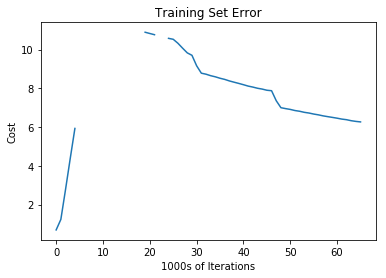

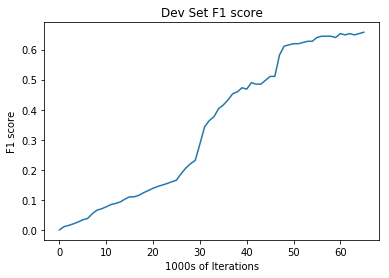

The train set F1 score is: 0.550394390885
The dev set F1 score is: 0.657534246575
The test set F1 score is: 0.451127819549


In [15]:
run_model(TrainTestDevSets, hyperparameters)

# Improving the model's performance
We can now tune the hyperparameters to improve the model's performance. From the previous run's graphs it appears that both the training set error could have been reduced, and the dev set performances improved, if the model had trained faster or longer. So let's increase training number of epochs.

Training the model, epoch: 1
Cost after iteration 0: 0.693682221943
F1 score on dev set: 0


/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


Cost after iteration 1000: nan
F1 score on dev set: 0.0309501702259
Training the model, epoch: 2
Cost after iteration 0: nan
F1 score on dev set: 0.0794809407948
Cost after iteration 1000: nan
F1 score on dev set: 0.128859060403
Cost after iteration 2000: 10.5170818131
F1 score on dev set: 0.179439252336
Cost after iteration 3000: 9.86932015131
F1 score on dev set: 0.217294900222
Training the model, epoch: 3
Cost after iteration 0: 9.48164715051
F1 score on dev set: 0.266666666667
Cost after iteration 3000: 7.78244280941
F1 score on dev set: 0.461538461538
Training the model, epoch: 4
Cost after iteration 0: 6.78633242403
F1 score on dev set: 0.536312849162
Cost after iteration 1000: 6.47280737994
F1 score on dev set: 0.561403508772
Cost after iteration 2000: 6.17437739283
F1 score on dev set: 0.615384615385
Cost after iteration 3000: 5.88091693201
F1 score on dev set: 0.65306122449
Cost after iteration 4000: 5.64780763285
F1 score on dev set: 0.644295302013
Cost after iteration 5000: 

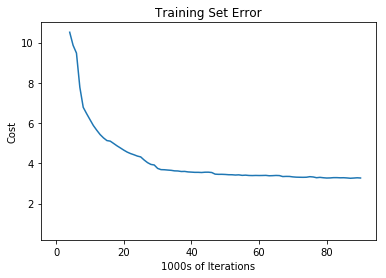

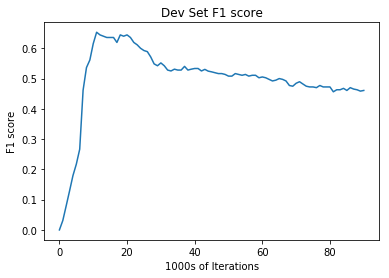

The train set F1 score is: 0.412677006069
The dev set F1 score is: 0.460784313725
The test set F1 score is: 0.306818181818


In [21]:
hyperparameters["num_epochs"] = 15
run_model(TrainTestDevSets, hyperparameters)

The increased number of epochs and the graph shows that the train and dev set performance have actually decreased, suggesting that there is actually a high bias issue with the model. We could fix this by creating a deeper model with more layers.

Training the model, epoch: 1
Cost after iteration 0: 0.695124411948
F1 score on dev set: 0


/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


Cost after iteration 1000: 3.77417759127
F1 score on dev set: 0.723404255319
Training the model, epoch: 2
Cost after iteration 0: 2.73359551292
F1 score on dev set: 0.838095238095
Cost after iteration 1000: 2.39578619958
F1 score on dev set: 0.882882882883
Cost after iteration 2000: 3.20417304611
F1 score on dev set: 0.662162162162
Cost after iteration 3000: 3.49683749238
F1 score on dev set: 0.680555555556
Training the model, epoch: 3
Cost after iteration 0: 3.53293319314
F1 score on dev set: 0.736842105263
Cost after iteration 3000: 3.31033473032
F1 score on dev set: 0.793388429752
Training the model, epoch: 4
Cost after iteration 0: 3.3437815394
F1 score on dev set: 0.716417910448
Cost after iteration 1000: 3.33668100727
F1 score on dev set: 0.711111111111
Cost after iteration 2000: 3.31114096834
F1 score on dev set: 0.716417910448
Cost after iteration 3000: 3.28467866547
F1 score on dev set: 0.732824427481
Cost after iteration 4000: 3.27899410182
F1 score on dev set: 0.727272727273

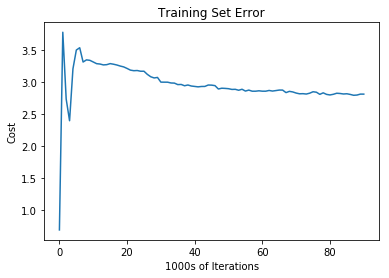

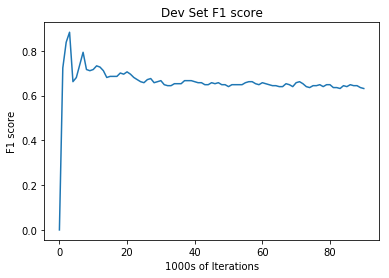

The train set F1 score is: 0.544978165939
The dev set F1 score is: 0.635761589404
The test set F1 score is: 0.436090225564


In [23]:
hyperparameters["layers_units"] = [X.shape[0], 128, 128, 128 , 64, 64, 32, 1]
The train set F1 score is: 0.544978165939
The dev set F1 score is: 0.635761589404
The test set F1 score is: 0.436090225564run_model(TrainTestDevSets, hyperparameters)

This has a positive effect, but both the train set error and dev set score graphs plateaued after a while, suggesting we could try an even deeper model.

Training the model, epoch: 1
Cost after iteration 0: 0.697252031686
F1 score on dev set: 0.00392486683488


/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


Cost after iteration 1000: nan
F1 score on dev set: 0.849056603774
Training the model, epoch: 2
Cost after iteration 0: 1.80457496695
F1 score on dev set: 0.87037037037
Cost after iteration 1000: 1.73082646311
F1 score on dev set: 0.890909090909
Cost after iteration 2000: 1.87899832226
F1 score on dev set: 0.890909090909
Cost after iteration 3000: 3.89491153324
F1 score on dev set: 0.7
Training the model, epoch: 3
Cost after iteration 0: 4.2148015511
F1 score on dev set: 0.79674796748
Cost after iteration 3000: 4.19568841011
F1 score on dev set: 0.823529411765
Training the model, epoch: 4
Cost after iteration 0: 4.58139458957
F1 score on dev set: 0.777777777778
Cost after iteration 1000: 4.64095762412
F1 score on dev set: 0.765625
Cost after iteration 2000: 4.65570994085
F1 score on dev set: 0.777777777778
Cost after iteration 3000: 4.67046965982
F1 score on dev set: 0.771653543307
Cost after iteration 4000: 4.69701406503
F1 score on dev set: 0.755905511811
Cost after iteration 5000: 4

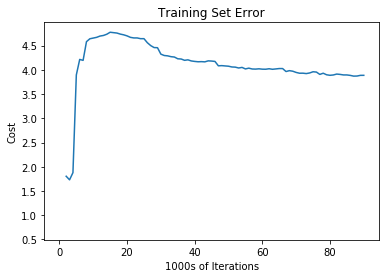

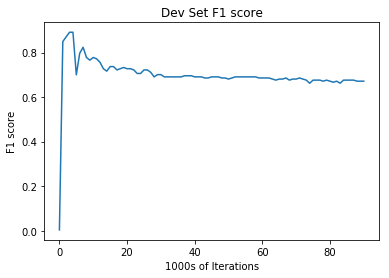

The train set F1 score is: 0.566515837104
The dev set F1 score is: 0.671328671329
The test set F1 score is: 0.459016393443


In [26]:
hyperparameters["layers_units"] = [X.shape[0], 256, 128, 256 , 64, 64, 64, 64, 32, 32, 1]
run_model(TrainTestDevSets, hyperparameters)

The train set F1 score is: 0.566515837104
The dev set F1 score is: 0.671328671329
The test set F1 score is: 0.459016393443

It seems based on the graphs that 15 epochs is too long to train the network, since the performance plateaus and even slightly decreases.

Training the model, epoch: 1
Cost after iteration 0: 0.698339486678
F1 score on dev set: 0.00392486683488


/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


Cost after iteration 1000: 1.38497024813
F1 score on dev set: 0.87037037037
Training the model, epoch: 2
Cost after iteration 0: 1.48305176173
F1 score on dev set: 0.880733944954
Cost after iteration 1000: 1.59477742966
F1 score on dev set: 0.880733944954
Cost after iteration 2000: 2.10345383365
F1 score on dev set: 0.857142857143
Cost after iteration 3000: 2.67861404778
F1 score on dev set: 0.844827586207
Training the model, epoch: 3
Cost after iteration 0: 2.87422290608
F1 score on dev set: 0.852173913043
Cost after iteration 3000: 3.44996622233
F1 score on dev set: 0.813559322034
Training the model, epoch: 4
Cost after iteration 0: 3.96038568729
F1 score on dev set: 0.759689922481
Cost after iteration 1000: 4.04840311854
F1 score on dev set: 0.732824427481
Cost after iteration 2000: 4.09992998593
F1 score on dev set: 0.75
Cost after iteration 3000: 4.14399070347
F1 score on dev set: 0.75
Cost after iteration 4000: 4.20563643787
F1 score on dev set: 0.727272727273
Cost after iteratio

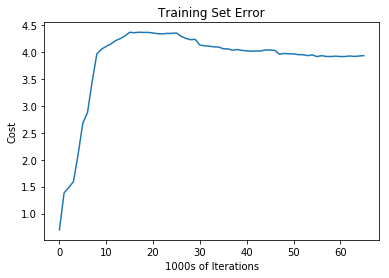

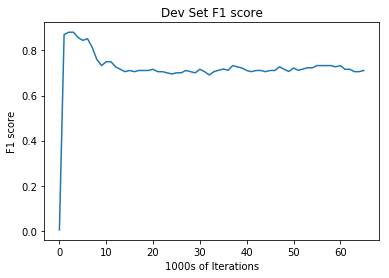

The train set F1 score is: 0.592307692308
The dev set F1 score is: 0.711111111111
The test set F1 score is: 0.48275862069


In [32]:
hyperparameters["layers_units"] = [X.shape[0], 256, 128, 256, 128, 64, 64, 64, 64, 64, 32, 1]
hyperparameters["num_epochs"] = 10
The train set F1 score is: 0.592307692308
The dev set F1 score is: 0.711111111111
The test set F1 score is: 0.48275862069run_model(TrainTestDevSets, hyperparameters)

This graph saw an improvement in the dev set F1 score, suggesting 10 epochs is sufficient for training and that any more does not increase performance. The network was made slightly deeper (by 1 layer) but a possible hyperparameter to tune that could boost performance is the number of hidden units in each layer - increasing the number could increase performance.

Training the model, epoch: 1
Cost after iteration 0: 0.717276129266
F1 score on dev set: 0.00392486683488


/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


Cost after iteration 1000: 2.64553953039
F1 score on dev set: 0.87037037037
Training the model, epoch: 2
Cost after iteration 0: 2.51633381394
F1 score on dev set: 0.890909090909
Cost after iteration 1000: 2.54187019203
F1 score on dev set: 0.890909090909
Cost after iteration 2000: 2.84323948041
F1 score on dev set: 0.890909090909
Cost after iteration 3000: 3.8192648291
F1 score on dev set: 0.867256637168
Training the model, epoch: 3
Cost after iteration 0: 4.40036532953
F1 score on dev set: 0.882882882883
Cost after iteration 3000: 7.21192566803
F1 score on dev set: 0.784
Training the model, epoch: 4
Cost after iteration 0: 8.70481490144
F1 score on dev set: 0.777777777778
Cost after iteration 1000: 8.73269770003
F1 score on dev set: 0.784
Cost after iteration 2000: 8.6433205194
F1 score on dev set: 0.790322580645
Cost after iteration 3000: 8.53568120177
F1 score on dev set: 0.803278688525
Cost after iteration 4000: 8.49269533113
F1 score on dev set: 0.784
Cost after iteration 5000: 8

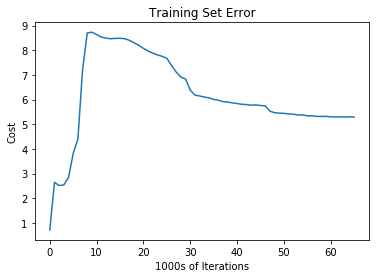

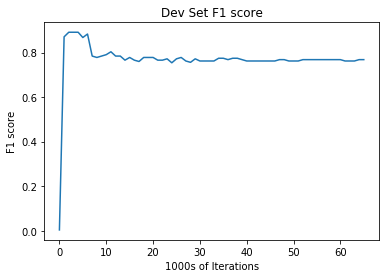

The train set F1 score is: 0.658798283262
The dev set F1 score is: 0.768
The test set F1 score is: 0.533333333333


In [34]:
hyperparameters["layers_units"] = [X.shape[0], 512, 512, 256, 256, 256, 128, 128, 128, 64, 64, 1]
hyperparameters["num_epochs"] = 10
run_model(TrainTestDevSets, hyperparameters)

The dev set score has increased, however subsequent increases in the number of layers did not substantially improve performance. So another hyperparameter that could be tuned is the batch size. 

Training the model, epoch: 1
Cost after iteration 0: 0.696165801163
F1 score on dev set: 0.00392486683488


/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/mukulrathi/anaconda/envs/dltestenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


Training the model, epoch: 2
Cost after iteration 0: nan
F1 score on dev set: 0.808080808081
Training the model, epoch: 3
Cost after iteration 0: nan
F1 score on dev set: 0.849056603774
Training the model, epoch: 4
Cost after iteration 0: nan
F1 score on dev set: 0.826923076923
Training the model, epoch: 5
Cost after iteration 0: nan
F1 score on dev set: 0.849056603774
Cost after iteration 1000: nan
F1 score on dev set: 0.87037037037
Training the model, epoch: 6
Cost after iteration 0: nan
F1 score on dev set: 0.826923076923
Training the model, epoch: 7
Cost after iteration 0: nan
F1 score on dev set: 0.851851851852
Training the model, epoch: 8
Cost after iteration 0: nan
F1 score on dev set: 0.834951456311
Cost after iteration 1000: nan
F1 score on dev set: 0.859813084112
Training the model, epoch: 9
Cost after iteration 0: nan
F1 score on dev set: 0.867924528302
Training the model, epoch: 10
Cost after iteration 0: nan
F1 score on dev set: 0.87037037037
Cost after iteration 1000: nan

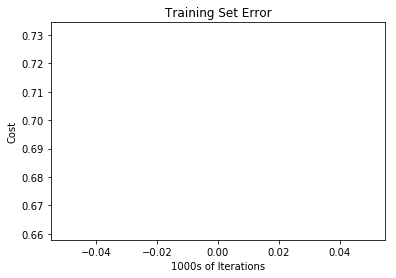

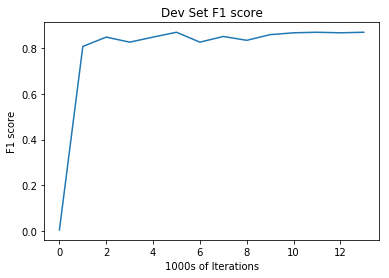

The train set F1 score is: 0.814419225634
The dev set F1 score is: 0.87037037037
The test set F1 score is: 0.708860759494


In [36]:
hyperparameters["batch_size"]= 1024
run_model(TrainTestDevSets, hyperparameters)

It is clear that increasing the batch size significantly improved performance. However, subsequent increases in layers, numbers of hidden units and batch size have not significantly improved performance, so this set of hyperparameters is the best setting for the model given the current data sets.

# Looking ahead
The dev set F1 score reached 0.87 with some hyperparameter tuning, however there is a huge disparity with the dev and test sets' F1 scores, suggesting that the model has been overfit to the dev set. In future, this could be minimised by having a larger dev set (perhaps using a 70:15:15 split rather than an 80:10:10 split between train, dev and test sets.